# Forecast Netflix Price : Time Series

## Downloading Package

In [5]:
! pip install opendatasets

# **Import Library dan Dataset**

In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import opendatasets as od

from sklearn.preprocessing import MinMaxScaler


Sumber : [dataset](https://www.kaggle.com/aayushmishra1512/netflix-stock-data)

In [7]:
od.download('https://www.kaggle.com/datasets/aayushmishra1512/netflix-stock-data')

Skipping, found downloaded files in "./netflix-stock-data" (use force=True to force download)


In [8]:
df = pd.read_csv('/content/netflix-stock-data/NFLX.csv')
print(f'Total data : {df.shape[0]}')
df.head()

Total data : 4581


,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.6+ KB


## Check Missing Value

In [10]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Ploting Price Netflix

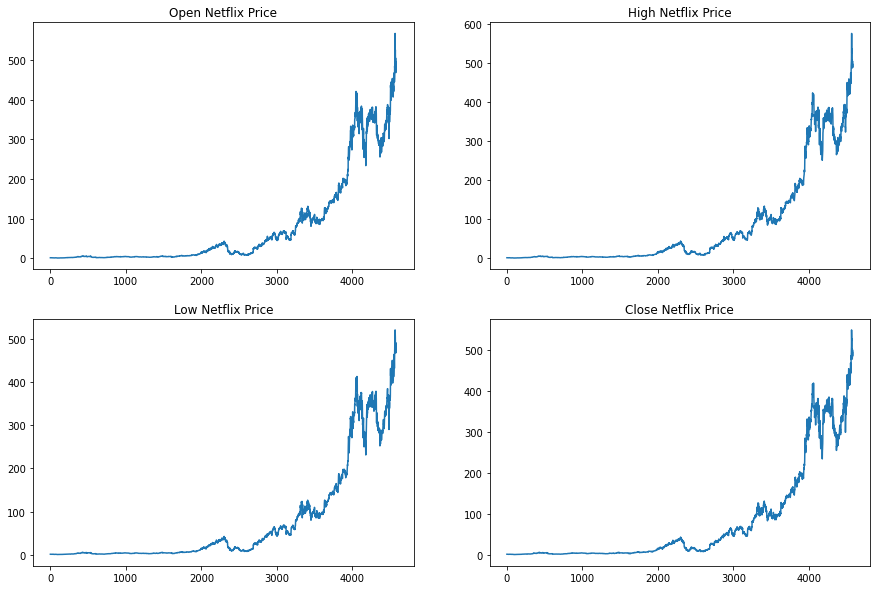

In [11]:
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

x = df.index

axis[0,0].plot(x, df['Open'])
axis[0,0].set_title('Open Netflix Price')

axis[0,1].plot(x, df['High'])
axis[0,1].set_title('High Netflix Price')

axis[1,0].plot(x, df['Low'])
axis[1,0].set_title('Low Netflix Price')

axis[1,1].plot(x, df['Close'])
axis[1,1].set_title('Close Netflix Price')
plt.show()

## Focusing on Open Price

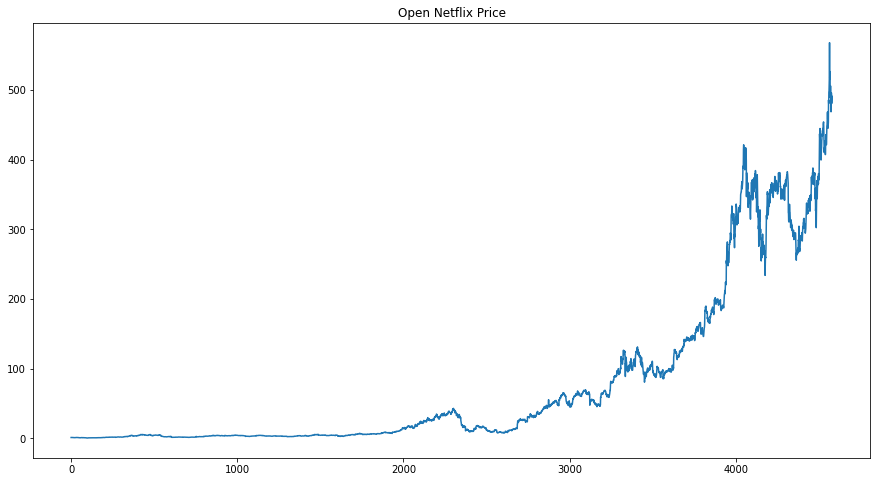

In [12]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Open'])
plt.title('Open Netflix Price')
plt.show()

> the data look have so much steady, so im go select data with fluctuating

In [13]:
df_new = df[2200:]
print(f'New Total data : {df_new.shape[0]}')

New Total data : 2381


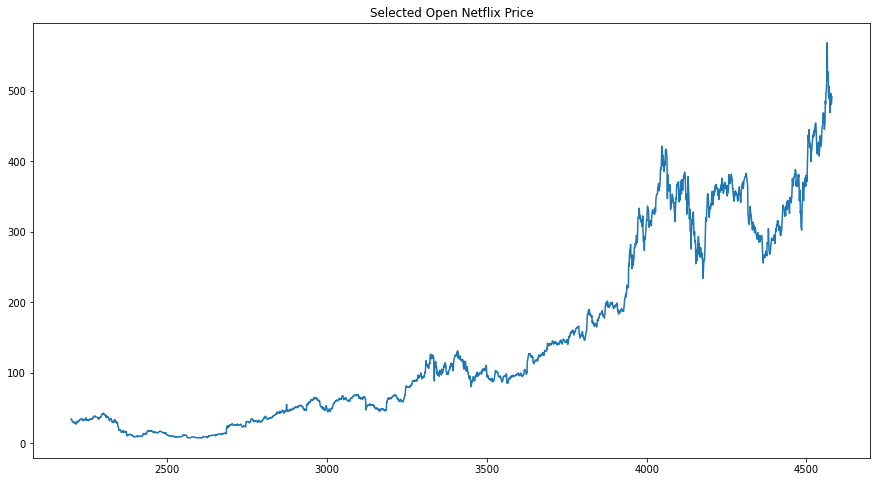

In [14]:
plt.figure(figsize=(15,8))
plt.plot(df_new.index, df_new['Open'])
plt.title('Selected Open Netflix Price')
plt.show()

## Fixed Partition

In [15]:
split_data = int(df_new.shape[0] * (20/100)) # split data 20%

df_train = df_new[split_data:]
df_val = df_new[:split_data]

print(f'Total Data Train : {df_train.shape[0]}')
print(f'Total Data Validation : {df_val.shape[0]}')

Total Data Train : 1905
Total Data Validation : 476


In [16]:
T_date = df_train['Date'].values
T_price = df_train['Open'].values

V_date = df_val['Date'].values
V_price = df_val['Open'].values

# reshape matrix
T_price_r = T_price.reshape(-1,1)
V_price_r = V_price.reshape(-1,1)

## Transform data

In [17]:
scaler = MinMaxScaler()
T_price_r_s = scaler.fit_transform(T_price_r)
V_price_r_s = scaler.fit_transform(V_price_r)

## Time Window Function

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
data_x_train = windowed_dataset(T_price_r_s, window_size=60, batch_size=68, shuffle_buffer=1000)
data_x_test = windowed_dataset(V_price_r_s, window_size=60, batch_size=68, shuffle_buffer=1000)

# Train Model
On this Train Im using Long short Term Memory layers

## LSTM Model
With Learning-rate Schedule to find best learning rate

In [24]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True), 
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [25]:
hist = model.fit(data_x_train ,epochs=100, validation_data=data_x_test, callbacks=[lr_schedule])

Epoch 1/100
28/28 [==============================] - 7s 85ms/step - loss: 14.5980 - mae: 15.0897 - val_loss: 15.9530 - val_mae: 16.4418 - lr: 1.0000e-07
Epoch 2/100
28/28 [==============================] - 2s 48ms/step - loss: 14.5451 - mae: 15.0367 - val_loss: 15.9020 - val_mae: 16.3905 - lr: 1.1220e-07
Epoch 3/100
28/28 [==============================] - 2s 48ms/step - loss: 14.5199 - mae: 15.0114 - val_loss: 15.8452 - val_mae: 16.3334 - lr: 1.2589e-07
Epoch 4/100
28/28 [==============================] - 2s 49ms/step - loss: 14.4589 - mae: 14.9503 - val_loss: 15.7826 - val_mae: 16.2705 - lr: 1.4125e-07
Epoch 5/100
28/28 [==============================] - 2s 49ms/step - loss: 14.3918 - mae: 14.8830 - val_loss: 15.7124 - val_mae: 16.2000 - lr: 1.5849e-07
Epoch 6/100
28/28 [==============================] - 2s 47ms/step - loss: 14.3300 - mae: 14.8211 - val_loss: 15.6328 - val_mae: 16.1200 - lr: 1.7783e-07
Epoch 7/100
28/28 [==============================] - 2s 47ms/step - loss: 14.2328 

## Plot Lr Schedule to find best Lr

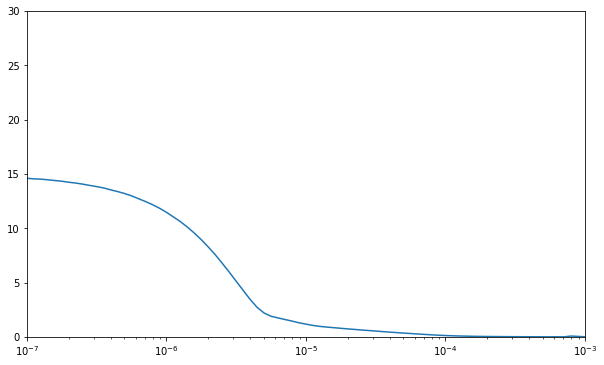

In [27]:
plt.figure(figsize=(10,6))
plt.semilogx(hist.history["lr"], hist.history["loss"])
plt.axis([1e-7, 1e-3, 0, 30])
plt.show()

> Stabil lr on 1e-5

## Declare Callbacks

In [28]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)

## Train model with best Learning_rate

In [29]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True), 
  tf.keras.layers.LSTM(100, return_sequences=True),
  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [30]:
hist = model.fit(data_x_train ,epochs=100, validation_data=data_x_test, callbacks=[model_checkpoint,early_stopping])

Epoch 1/100
28/28 [==============================] - 9s 136ms/step - loss: 0.9331 - mae: 1.3084 - val_loss: 0.1246 - val_mae: 0.4515
Epoch 2/100
28/28 [==============================] - 2s 59ms/step - loss: 0.7744 - mae: 1.1315 - val_loss: 0.0516 - val_mae: 0.2231
Epoch 3/100
28/28 [==============================] - 2s 61ms/step - loss: 0.6925 - mae: 1.0190 - val_loss: 0.0428 - val_mae: 0.1947
Epoch 4/100
28/28 [==============================] - 2s 53ms/step - loss: 0.6276 - mae: 0.9416 - val_loss: 0.0332 - val_mae: 0.1762
Epoch 5/100
28/28 [==============================] - 2s 49ms/step - loss: 0.5682 - mae: 0.8724 - val_loss: 0.0295 - val_mae: 0.1662
Epoch 6/100
28/28 [==============================] - 2s 50ms/step - loss: 0.5093 - mae: 0.8029 - val_loss: 0.0283 - val_mae: 0.1615
Epoch 7/100
28/28 [==============================] - 2s 50ms/step - loss: 0.4630 - mae: 0.7482 - val_loss: 0.0277 - val_mae: 0.1587
Epoch 8/100
28/28 [==============================] - 2s 50ms/step - loss: 0

In [33]:
model = tf.keras.models.load_model("my_checkpoint.h5")

## Plot MAE dan Loss

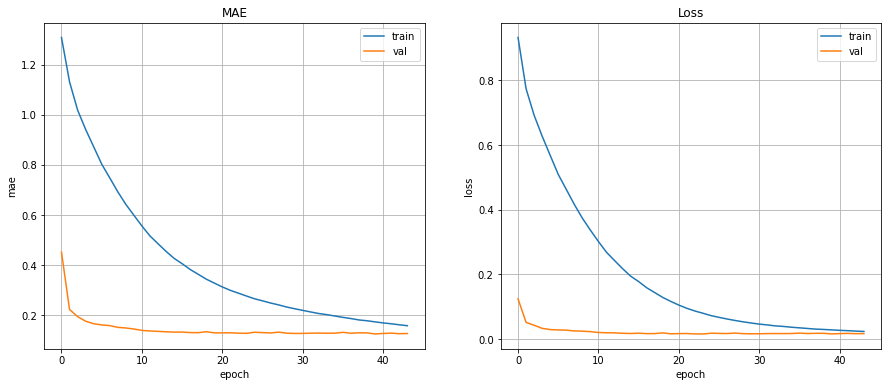

In [48]:

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid()
plt.show()